In [1]:
import configparser
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.linear_model import LinearRegression

config = configparser.ConfigParser()
config.read('../../config.ini')
ts_path = config['paths']['ts_course_path']

# Model A

Model: $$NumberV_t = \beta_0 + \beta_1*T + \varepsilon$$

* The model captures the linear temporal trend.

## Load

In [2]:
#number of vehicles traveling through the Baregg Tunnel in Switzerland 
# each day from November 2003 to November 2005
tunnel_data = pd.read_csv(os.path.join(ts_path, 'tunnel.csv'), parse_dates=['Day']) # parse Day col to Datetime64
tunnel_data.head()

,Day,NumVehicles
0,2003-11-01,103536
1,2003-11-02,92051
2,2003-11-03,100795
3,2003-11-04,102352
4,2003-11-05,106569


In [3]:
tunnel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Day          747 non-null    datetime64[ns]
 1   NumVehicles  747 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.8 KB


In [4]:
print(tunnel_data['Day'].min(), tunnel_data['Day'].max())

2003-11-01 00:00:00 2005-11-16 00:00:00


## Preprocessing

In [5]:
# 1. Set index
# 2. Convert the index to Period type
# 3. Feature engineering

# set index
tunnel_data = tunnel_data.set_index('Day')

# By default, Pandas creates a `DatetimeIndex` with dtype `Timestamp`
# (equivalent to `np.datetime64`, representing a time series as a
# sequence of measurements taken at single moments. A `PeriodIndex`,
# on the other hand, represents a time series as a sequence of
# quantities accumulated over periods of time. Periods are often
# easier to work with, so that's what we'll use in this course.
tunnel_data = tunnel_data.to_period()

# Feature engineering
tunnel_data['Time'] = np.arange(len(tunnel_data['NumVehicles']))

tunnel_data.head()

,NumVehicles,Time
Day,,
2003-11-01,103536,0
2003-11-02,92051,1
2003-11-03,100795,2
2003-11-04,102352,3
2003-11-05,106569,4


In [6]:
## Model
X = tunnel_data.loc[:, ['Time']]
y = tunnel_data.loc[:, ['NumVehicles']]

model = LinearRegression()
model.fit(X, y)

y_predict = pd.Series(model.predict(X).flatten(), index=X.index)

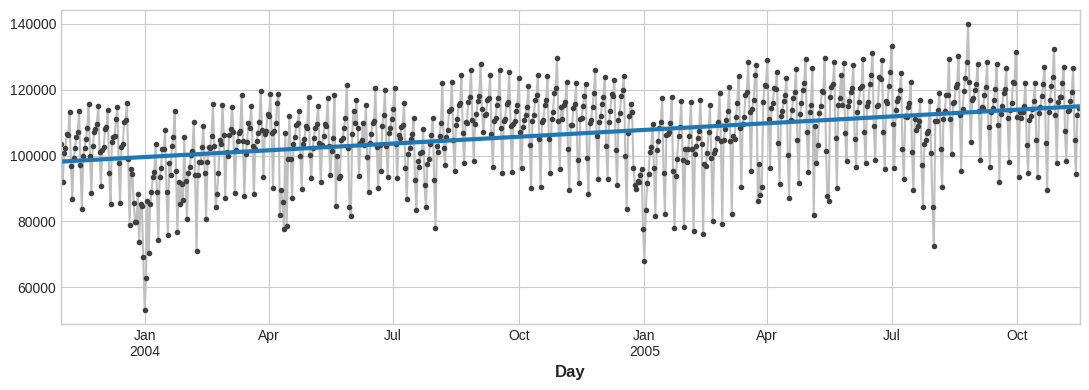

In [7]:
## plot
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

ax = y.plot(**plot_params)
ax = y_predict.plot(ax=ax, linewidth=3)

In [8]:
y_predict

Day
2003-11-01     98176.206344
2003-11-02     98198.703794
2003-11-03     98221.201243
2003-11-04     98243.698693
2003-11-05     98266.196142
                  ...      
2005-11-12    114869.313898
2005-11-13    114891.811347
2005-11-14    114914.308797
2005-11-15    114936.806247
2005-11-16    114959.303696
Freq: D, Length: 747, dtype: float64

# Model B

Model: $$NumberV_t = \beta_0 + \beta_1*T + \beta_2*NumberV_{t-1} + \varepsilon$$

* The model captures the linear temporal trend and one lag.

## Preprocessing

In [9]:
tunnel_data['NumVehicles_l1'] = tunnel_data['NumVehicles'].shift(1)
tunnel_data = tunnel_data.dropna()
tunnel_data.head()

,NumVehicles,Time,NumVehicles_l1
Day,,,
2003-11-02,92051,1,103536.0
2003-11-03,100795,2,92051.0
2003-11-04,102352,3,100795.0
2003-11-05,106569,4,102352.0
2003-11-06,106284,5,106569.0


## Model

In [10]:
tunnel_data[['NumVehicles_l1', 'Time']]

,NumVehicles_l1,Time
Day,,
2003-11-02,103536.0,1
2003-11-03,92051.0,2
2003-11-04,100795.0,3
2003-11-05,102352.0,4
2003-11-06,106569.0,5
...,...,...
2005-11-12,126650.0,742
2005-11-13,104646.0,743
2005-11-14,94424.0,744


In [11]:
X = tunnel_data[['NumVehicles_l1', 'Time']]
y = tunnel_data['NumVehicles']


model = LinearRegression()
model.fit(X, y)
y_predict = pd.Series(model.predict(X), index=X.index)

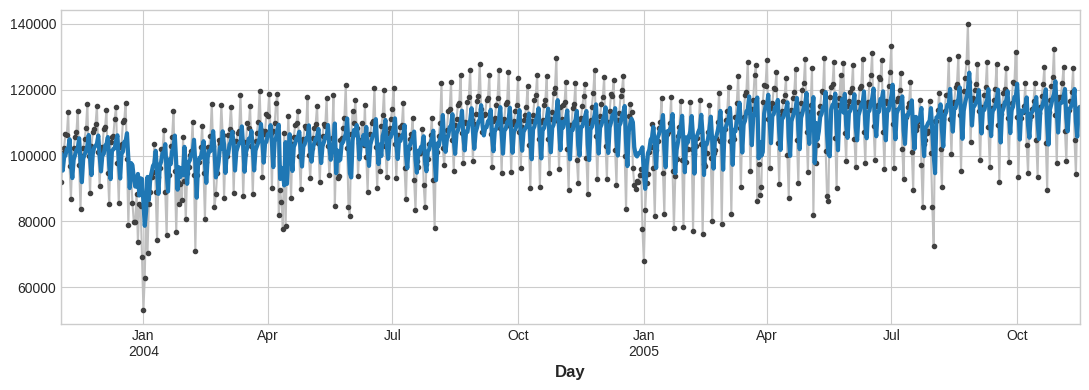

In [12]:
ax = y.plot(**plot_params)
ax = y_predict.plot(ax=ax, linewidth=3)